In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from pandas import concat
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [2]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [3]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [4]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [5]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [6]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

## Decision Tree

### Walk-forward

In [7]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [8]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)
dt_data = series_to_supervised(X, n_in=4)

In [9]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

In [10]:
from sklearn.tree import DecisionTreeRegressor


In [11]:
# walk-forward validation for univariate data
def dt_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = decision_tree_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [12]:
# fit an random forest model and make a one step prediction
def decision_tree_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = DecisionTreeRegressor(random_state=42)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 print(yhat)
 return yhat[0]

[-5.71454615]
>expected=7.5, predicted=-5.7
[7.45821383]
>expected=7.8, predicted=7.5
[7.83274999]
>expected=3.5, predicted=7.8
[3.52511322]
>expected=3.9, predicted=3.5
[5.50021781]
>expected=6.8, predicted=5.5
[5.50021781]
>expected=2.1, predicted=5.5
MAE: 3.821
ME: -1.236
RMSE: 5.857
Direction Accuracy: 0.400


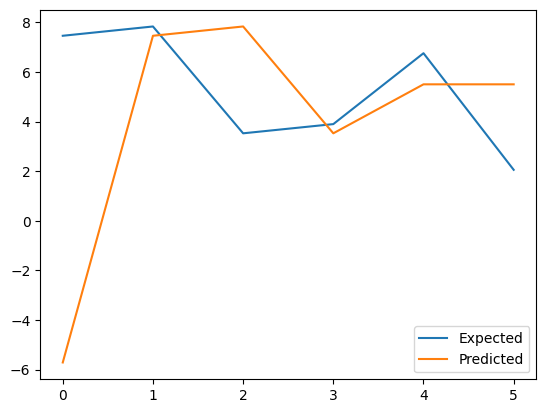

In [13]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = dt_walk_forward_validation(dt_data, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

### Rolling forecast for Decision Tree

Since this method uses 4 lagged values as input for predicting the next step, we are exposing the test data set in every iteration. So essentially this is a forecast with a window of "input" moving along the test set, predicting one step at a time, but having been trained on the original training set only once.

In [14]:
train, test = train_test_split(dt_data, 6)
train = asarray(train)
trainX, trainy = train[:, :-1], train[:, -1]


In [18]:
model_dt_rolling = DecisionTreeRegressor(random_state=42, max_depth = 3)
model_dt_rolling.fit(trainX, trainy)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [19]:
predictions = list()
direction_accuracies = list() 

In [20]:
for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
    print([testX])
    yhat = model_dt_rolling.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat[0])
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


[array([18.51417816, 28.98555411, 16.84723416,  4.06330439])]
>expected=7.5, predicted=4.7
[array([28.98555411, 16.84723416,  4.06330439,  7.45821383])]
>expected=7.8, predicted=4.7
[array([16.84723416,  4.06330439,  7.45821383,  7.83274999])]
>expected=3.5, predicted=4.7
[array([4.06330439, 7.45821383, 7.83274999, 3.52511322])]
>expected=3.9, predicted=4.7
[array([7.45821383, 7.83274999, 3.52511322, 3.89640241])]
>expected=6.8, predicted=4.7
[array([7.83274999, 3.52511322, 3.89640241, 6.75448265])]
>expected=2.1, predicted=4.7


In [160]:
test[0, :-1]

array([18.51417816, 28.98555411, 16.84723416,  4.06330439])

In [161]:
model_dt_rolling.predict([test[0, :-1]])

array([-5.71454615])

In [162]:
[test[1, :-1]]

[array([28.98555411, 16.84723416,  4.06330439,  7.45821383])]

In [163]:
model_dt_rolling.predict([test[1, :-1]])

array([-5.71454615])

In [164]:
[test[2, :-1]]

[array([16.84723416,  4.06330439,  7.45821383,  7.83274999])]

In [165]:
model_dt_rolling.predict([test[2, :-1]])

array([-5.71454615])

In [166]:
for i in range(len(test)):
    print(test[i, :-1])

[18.51417816 28.98555411 16.84723416  4.06330439]
[28.98555411 16.84723416  4.06330439  7.45821383]
[16.84723416  4.06330439  7.45821383  7.83274999]
[4.06330439 7.45821383 7.83274999 3.52511322]
[7.45821383 7.83274999 3.52511322 3.89640241]
[7.83274999 3.52511322 3.89640241 6.75448265]


In [167]:
test

array([[18.51417816, 28.98555411, 16.84723416,  4.06330439,  7.45821383],
       [28.98555411, 16.84723416,  4.06330439,  7.45821383,  7.83274999],
       [16.84723416,  4.06330439,  7.45821383,  7.83274999,  3.52511322],
       [ 4.06330439,  7.45821383,  7.83274999,  3.52511322,  3.89640241],
       [ 7.45821383,  7.83274999,  3.52511322,  3.89640241,  6.75448265],
       [ 7.83274999,  3.52511322,  3.89640241,  6.75448265,  2.0532646 ]])

In [168]:
predictions

[-5.714546148302031,
 -5.714546148302031,
 -5.714546148302031,
 -5.714546148302031,
 -5.714546148302031,
 -5.714546148302031]

In [112]:
test[:, -1]

array([7.45821383, 7.83274999, 3.52511322, 3.89640241, 6.75448265,
       2.0532646 ])

MAE: 10.968
ME: -10.968
RMSE: 11.185
Direction Accuracy: 0.000


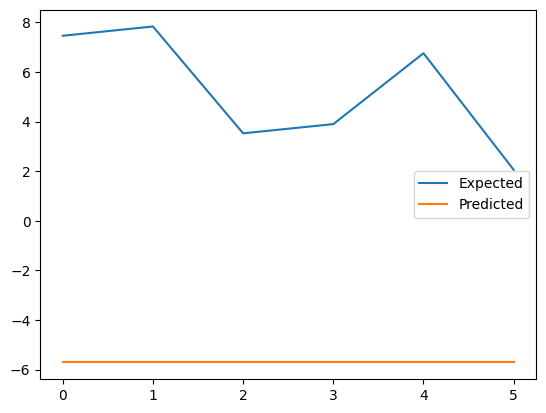

In [169]:
error = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

print('MAE: %.3f' % error)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(test[:, -1], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

## Static (Multi-step) Forecast

Since the above methods use the 4-week lagged values as inputs, it is not possible to use the same method to do static (multi-step) forecasting. For this, we will need to train the model on the original training dataset, not expose it to the test data set and ask it to predict for 6 steps ahead. 

This can be achieved using the ForecasterAutoreg class from the SKforecast package. This class turns any regressor compatible with the scikit-learn API into a recursive autoregressive (multi-step) forecaster.

In [47]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [48]:
# Define the forecaster
forecaster = ForecasterAutoreg(
    # Add the sklearn regressor and lags
    regressor = DecisionTreeRegressor(random_state = 123),
    lags = 4
)

In [49]:
y_train = df_train['wPreis']

# Check if y_train is a pandas Series
# print(isinstance(y_train, pd.Series))  # Should print True

In [50]:
# Now you can pass y_train to forecaster.fit()
forecaster.fit(y=y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [51]:
# Predict the test period
predicted_test = forecaster.predict(steps = len(df_test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [52]:
predicted_test

4   -5.714546
5   -0.307413
6   -5.714546
7   -0.307413
8    7.293524
9    8.006889
Name: pred, dtype: float64

In [53]:
def forecast_accuracy(forecast, actual):
      error = mean_absolute_error(actual, forecast) # MAE
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae': error, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [54]:
predicted_test.index = df_test.index


Decision Tree Static Forecast Accuracy of: wPreis
mae    :  6.8748
me     :  -4.7106
rmse   :  7.9432
direction_accuracy :  0.8


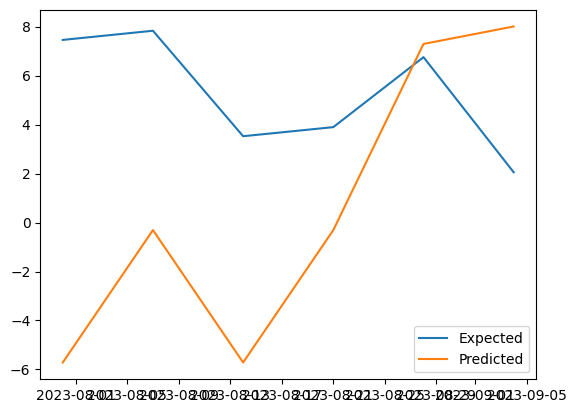

In [56]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Static Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(predicted_test, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predicted_test, label='Predicted')
plt.legend()
plt.show()

## Walk-forward validation

Now we try the Walk-forward validation using the ForecasterAutoreg to check the results against the standard method

In [57]:
history = y_train 

In [58]:
predictions = list()
for t in range(len(df_test)): # 6 times reiterate
    forecaster.fit(y=history)
    output = forecaster.predict(steps = 1)
    predictions.append(output)
    obs = df_test['wPreis'][t]
    obs_series = pd.Series(obs)
    history = history.append(obs_series, ignore_index=True)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [59]:
predictions 

[4   -5.714546
 Name: pred, dtype: float64,
 149    7.458214
 Name: pred, dtype: float64,
 150    7.83275
 Name: pred, dtype: float64,
 151    3.525113
 Name: pred, dtype: float64,
 152    3.896402
 Name: pred, dtype: float64,
 153    3.896402
 Name: pred, dtype: float64]

In [60]:
predictions_series = pd.concat(predictions, ignore_index=True)
predictions_series.index = df_test.index
predictions_series

date
2023-07-31   -5.714546
2023-08-07    7.458214
2023-08-14    7.832750
2023-08-21    3.525113
2023-08-28    3.896402
2023-09-04    3.896402
Name: pred, dtype: float64

In [61]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Walk-forward Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(predictions_series, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Decision Tree Walk-forward Forecast Accuracy of: wPreis
mae    :  3.8212
me     :  -1.771
rmse   :  5.8298
direction_accuracy :  0.4


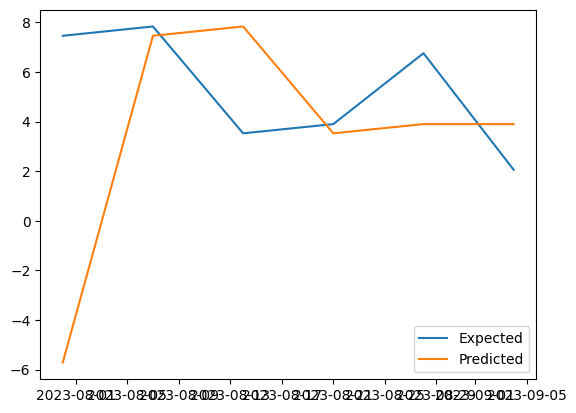

In [62]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predictions_series, label='Predicted')
plt.legend()
plt.show()

This was walk-forward validation